In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

campaigns = pd.read_csv('CampaignHistory.csv', parse_dates=['Email Sent Date'])
applications = pd.read_csv('ApplicationData.csv', parse_dates=['Application Start  Date'])

In [2]:
#all company_ids in applications have started applications
applications['Started Application'].unique()

array([1])

In [3]:
campaigns.Creative.loc[campaigns.Creative =='Alternative Creative ']='Alternative Creative'

#Number of campaign emails sent on each date
campaigns.groupby(['Creative', 'Email Sent Date']).agg({'Company ID':'count'})

/Users/Xinny/PycharmProjects/funding_circle_analysis/venv/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Company ID
Creative             Email Sent Date            
Alternative Creative 2018-03-01             1949
Default Creative     2018-02-01             1876
                     2018-04-01             1579

In [4]:
# all users were only exposed to one --> eliminates relative order sensitivity
campaigns['Company ID'].nunique()

5404

In [5]:
# renaming columns
applications = applications.rename(columns={'Application Start  Date':'application_start_date', 
                                            'Fully Completed Application':'finished_application',
                                           'Started Application': 'started_application'})

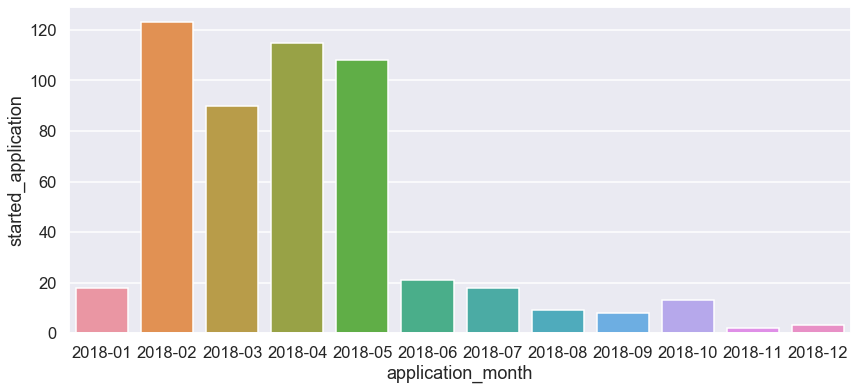

In [28]:
# Joining Applications to Campaign info
campaign_applications = pd.merge(campaigns,applications, on='Company ID', how = 'outer')

#adding month col to applications
campaign_applications['application_month'] = campaign_applications['application_start_date'].dt.to_period('M')

applications_month = campaign_applications.groupby('application_month').agg({'Company ID':'count',
                                                                         'started_application':'sum', 
                                                                         'finished_application':'sum', 
                                                                          'Loan Offer': 'sum', 
                                                                          'Loan Accepted':'sum'}).reset_index()

sns.set(rc={'figure.figsize':(14,6)})
sns.set_context('talk')
sns.barplot(data =applications_month, x='application_month', y='started_application')

##### The campaigns were delievered in Feb(D), March(A) and April(D). There are 2 observations we can see in this graph:
    
    1.On the months of the Default campaign, there seems to be high sign ups.
    2.The high number of applications in May, despite no campaign shows that there are other factors that greatly influence the loan application rate.

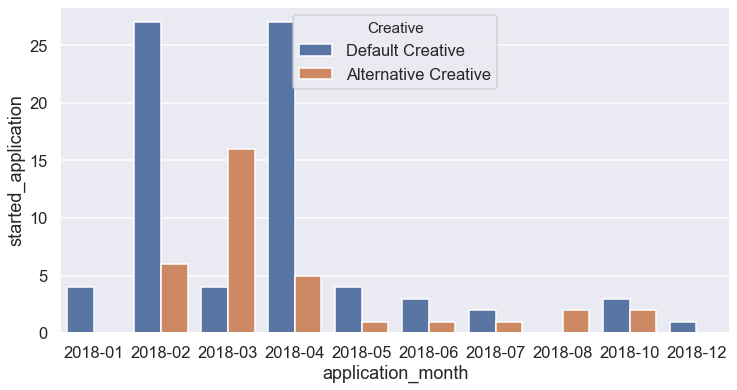

In [34]:
#applications with null in Creative should have No Campaign filled
campaign_applications=campaign_applications.dropna(subset=['Creative'])

#applications by month
campaign_applications_by_month = campaign_applications.groupby(['application_month', 'Creative']).agg({'Company ID':'count',
                                                                         'started_application':'sum', 
                                                                         'finished_application':'sum', 
                                                                          'Loan Offer': 'sum', 
                                                                          'Loan Accepted':'sum',
                                                                          'Loan Amount':'sum'}).reset_index()

sns.set(rc={'figure.figsize':(12,6)})
sns.set_context('talk')
sns.barplot(data =campaign_applications_by_month, x='application_month', y='started_application', hue='Creative')

##### For both campaign types, there were a small amount of people who had already signed up, howevr the sample size is too small to test.

##### Another key metric is the fact that on both of the months where Default Creatives were sent out, there was a large number of signups. The conversion rate calculated below also agrees with the visualisation.

In [35]:
# 0 to represent No, 1 to represent Yes
campaign_applications['stared_application'] = campaign_applications['started_application'].fillna(0, inplace=True)

import numpy as np
campaign_summary = campaign_applications.pivot_table(values='started_application', index='Creative', aggfunc=np.sum)
campaign_summary['total'] = campaign_applications.pivot_table(values='started_application', index='Creative', aggfunc=lambda x: len(x))
campaign_summary['rate'] = campaign_applications.pivot_table(values='started_application', index='Creative')
campaign_summary['no_application'] = campaign_summary['total'] - campaign_summary['started_application']
campaign_summary

,started_application,total,rate,no_application
Creative,,,,
Alternative Creative,34.0,1949.0,0.017445,1915.0
Default Creative,75.0,3455.0,0.021708,3380.0


In [36]:
summary = campaign_applications.groupby(['Creative']).agg({'started_application':'sum',
                                                                  'finished_application':'sum',
                                                                'Loan Offer':'sum',
                                                 'Loan Accepted':'sum',
                                                                  'Loan Amount':'sum'})
summary['loan_average'] = summary['Loan Amount']/summary['Loan Offer']
summary

,started_application,finished_application,Loan Offer,Loan Accepted,Loan Amount,loan_average
Creative,,,,,,
Alternative Creative,34.0,20.0,14.0,12.0,1525915.0,108993.928571
Default Creative,75.0,50.0,38.0,28.0,2473201.0,65084.236842


##### Although there are few sign ups and a lower conversion rate, we can see that the alternative creative generated a higher average approved loan amount - this shows that althought the alternative is not best performing in terms of campaign rate from our sample, it attracts higher value loan applications.

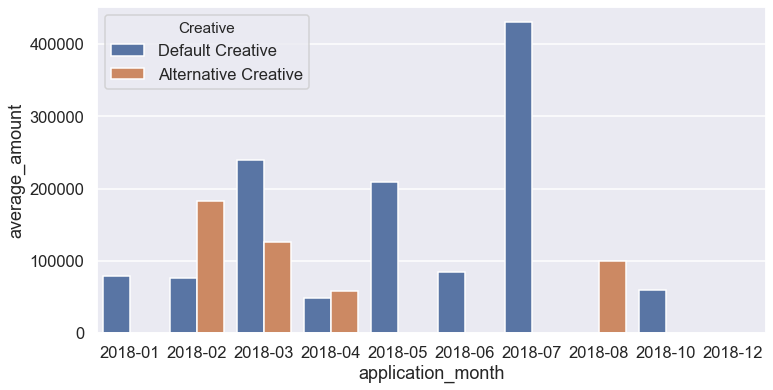

In [40]:
campaign_applications_by_month['average_amount'] = campaign_applications_by_month['Loan Amount']/campaign_applications_by_month['Loan Accepted']

#applications amounts by month
sns.set(rc={'figure.figsize':(12,6)})
sns.set_context('talk')
sns.barplot(data =campaign_applications_by_month, x='application_month', y='average_amount', hue='Creative')

##### If we look at the average loan amounts by month by creative type and combine it with the information we have above about the number of sign ups, it appears that the Default application resulted in higher average loan values for those customers approved. This indicates that teh Alternatve Creatuve atttracted customers applying for some anomoulouly large loans

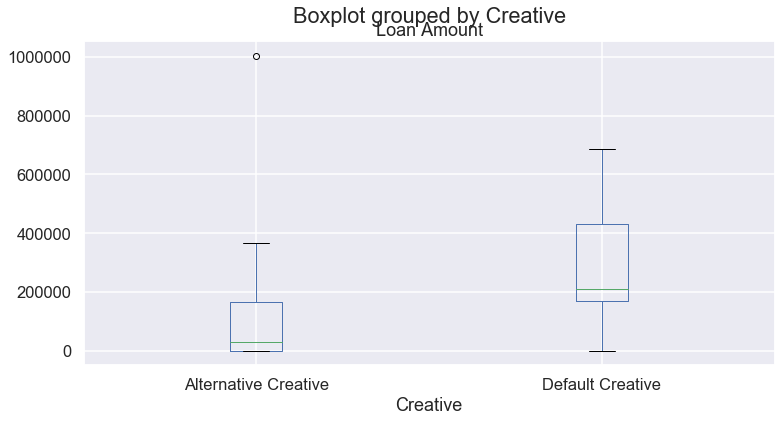

In [45]:
campaign_applications_by_month.boxplot('Loan Amount', by='Creative')

#### Here we can see that the average loan amount from the alternative creative was skewed by one loan application for £1 million.

#### Chi Squared test to test for significance of difference

H0: There is no difference in conversion rate based on creative used

H1: There is a difference in conversion rate of the creatives

In [43]:
from scipy import stats
c, p, df, table = stats.chi2_contingency([campaign_summary['started_application'],
                                          campaign_summary['no_application']])
print('chi squared statistic:{}, p value:{}'.format(c,p))

chi squared statistic:0.9401775985197799, p value:0.3322321720491406


p<0.05 is the usual test for independence.

Given the high p-value obtained, there is no significant difference in the conversion rates of the two campaigns.

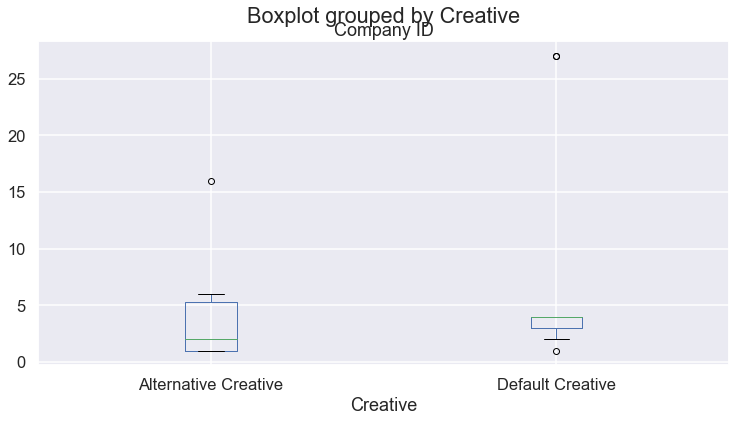

In [30]:
monthly_sign_up = campaign_applications.groupby(['application_month','Creative']).agg({'Company ID':'count'}).reset_index()
fig1 = monthly_sign_up.boxplot('Company ID', by='Creative')
fig1

In [23]:
#alternative creative data
alternative_creative = monthly_sign_up.loc[monthly_sign_up.Creative== 'Alternative Creative']

#only default creative data
default = monthly_sign_up.where(monthly_sign_up.Creative== 'Default Creative').dropna()
monthly_sign_up.groupby('Creative').describe()

Company ID                                            \
                          count      mean        std  min  25%  50%   75%   
Creative                                                                    
Alternative Creative        8.0  4.250000   5.119989  1.0  1.0  2.0  5.25   
Default Creative            9.0  8.333333  10.630146  1.0  3.0  4.0  4.00   

                            
                       max  
Creative                    
Alternative Creative  16.0  
Default Creative      27.0

In [24]:
stats.levene(alternative_creative['Company ID'], default['Company ID'])

LeveneResult(statistic=0.5807892777364111, pvalue=0.45781969881534423)

The test is not significant meaning there is homogeneity of variances and we can proceed.

((array([-1.49876728, -0.98494667, -0.64703803, -0.37109819, -0.12121409,
          0.12121409,  0.37109819,  0.64703803,  0.98494667,  1.49876728]),
  array([-12.,  -2.,   1.,   1.,   1.,   2.,   3.,   4.,  21.,  22.])),
 (10.088003030318125, 4.1, 0.9070875958490314))

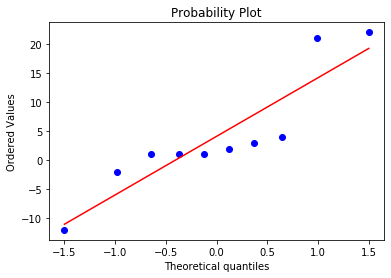

In [25]:
monthly_summary = monthly_sign_up.pivot(index='application_month', columns='Creative',
                    values = 'Company ID').fillna(0)
monthly_summary['diff'] = monthly_summary['Default Creative'] - monthly_summary['Alternative Creative']
stats.probplot(monthly_summary['diff'], plot= plt)

In [28]:
w, p = stats.shapiro(monthly_summary['diff'])
print('W: {}, p: {}'.format(w,p))

W: 0.836881697177887, p: 0.04048397019505501


Since the sample p-value is very low, this indicates that it is likely that the sample came from a population without a normal distribution (accept alternative hypothesis)

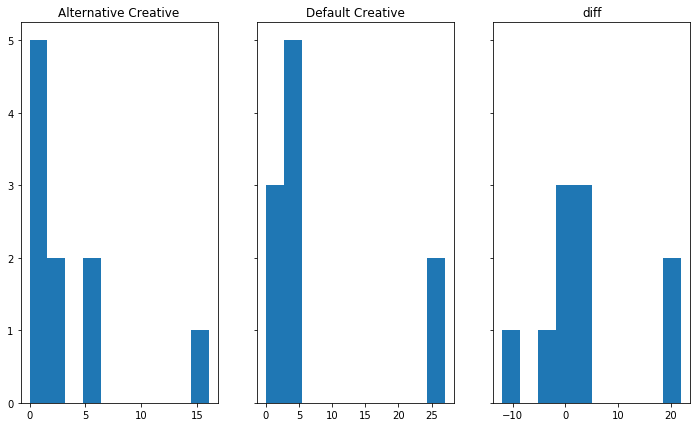

In [29]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel() 
for x in range(3):
    ax[x].hist(monthly_summary.iloc[:,x])
    ax[x].set_title(monthly_summary.columns[x])


### Wilcoxon test (non parametric equiv for t-test)
The distribution of average sign ups per day is not normally distributed so use non-parametric testing - Wilcoxon test instead of T test.

H0: There is no difference between the median daily sign up for the creatives used.

H1: There is a difference in the median daily sign up for each creative.

In [30]:
stats.wilcoxon(monthly_summary['diff'])

WilcoxonResult(statistic=12.5, pvalue=0.1250468801311004)

p>0.1, fail to reject null hypothesis, there is not a statistically significant difference in the median daily sign ups due to creative type

#### Unpaired t-test

In [31]:
#H0: There is no difference between number of signups per day and the Creative used in marketing
#H1: There is a difference between number of signups per day and the Creatuve used in marketing

import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind

t,p, DF = ttest_ind(default['Company ID'], alternative_creative['Company ID'])
print('t-value is {}\n p-value is {} \n degrees of freedom used {}'.format(t,p,DF))

t-value is 0.9869328807756822
 p-value is 0.3393288059106051 
 degrees of freedom used 15.0


The p-value, probablity of observing such an extreme value by chance, is not significant at the 0.1, 0.05 or 0.01 level. We have failed to reject the null hypothesis, there is no significant difference in the daily number of signups and the Creative used for email marketing.